In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from catboost import Pool
from catboost import cv
import catboost
import seaborn as sns

Мы решаем задачу предсказания одобрения грантовой заявки (задачу бинарной классификации). В качестве целевой метрики мы рассматриваем AUC. Напомним, что в обычной версии задания мы получили лучшие значения auc:

1. Логистическая регрессия -- 0,851;
2. Случайный лес -- 0,917.

В данном JupyterNotebook мы попробуем построить предсказательную модель с помощью градиентного спуска -- для этого мы воспользуемся фреймворком catboost.


In [2]:
df = pd.read_csv('grant_data_imb.csv')
df.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,0,97A,30B,A,321024.0,50.0,321013.0,30.0,291502.0,20.0,...,2563.0,25.0,Yes,>10 to 15,2.0,6.0,3.0,5.0,15.0,3.0
1,0,36D,10A,G,300201.0,100.0,0.0,0.0,0.0,0.0,...,1038.0,1.0,NaN,Less than 0,0.0,3.0,0.0,4.0,0.0,0.0
2,0,317A,30D,NaN,321013.0,100.0,0.0,0.0,0.0,0.0,...,2763.0,25.0,Yes,>5 to 10,4.0,3.0,6.0,25.0,14.0,14.0
3,0,62B,10B,B,321103.0,30.0,321105.0,40.0,321204.0,30.0,...,2848.0,25.0,NaN,Less than 0,1.0,2.0,1.0,0.0,0.0,0.0
4,0,1A,10A,NaN,270603.0,60.0,321205.0,30.0,320603.0,10.0,...,2678.0,25.0,Yes,>5 to 10,5.0,14.0,0.0,9.0,7.0,0.0


In [3]:
# Зафиксируем random seed
SEED = 1

In [4]:
cat_features = ['Sponsor.Code', 'Grant.Category.Code', 'Contract.Value.Band...see.note.A', 'RFCD.Code.1',
                 'RFCD.Code.2', 'RFCD.Code.3', 'RFCD.Code.4', 'RFCD.Code.5',
                 'SEO.Code.1', 'SEO.Code.2', 'SEO.Code.3', 'SEO.Code.4', 'SEO.Code.5', 'Person.ID.1', 'Role.1',
                 'Country.of.Birth.1', 'Home.Language.1',
                 'Dept.No..1', 'Faculty.No..1', 'With.PHD.1', 'No..of.Years.in.Uni.at.Time.of.Grant.1']

for feature in cat_features:
    df[feature] = df[feature].astype(str)

In [5]:
target = df['Grant.Status']
features = df.drop(['Grant.Status'], axis = 1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2,
                                                                             stratify=target, random_state=SEED)

In [6]:
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 200,
    'random_seed': SEED,
    'cat_features': cat_features
}

cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(features_train, target_train, eval_set = (features_test, target_test), use_best_model = True, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042526
0:	test: 0.8368538	best: 0.8368538 (0)	total: 112ms	remaining: 1m 51s
200:	test: 0.9304076	best: 0.9310803 (129)	total: 3.85s	remaining: 15.3s
400:	test: 0.9306408	best: 0.9310803 (129)	total: 7.4s	remaining: 11.1s
600:	test: 0.9314749	best: 0.9315915 (597)	total: 10.2s	remaining: 6.76s
800:	test: 0.9306587	best: 0.9316543 (610)	total: 13.6s	remaining: 3.37s
999:	test: 0.9302910	best: 0.9316543 (610)	total: 17s	remaining: 0us

bestTest = 0.9316542891
bestIteration = 610

Shrink model to first 611 iterations.


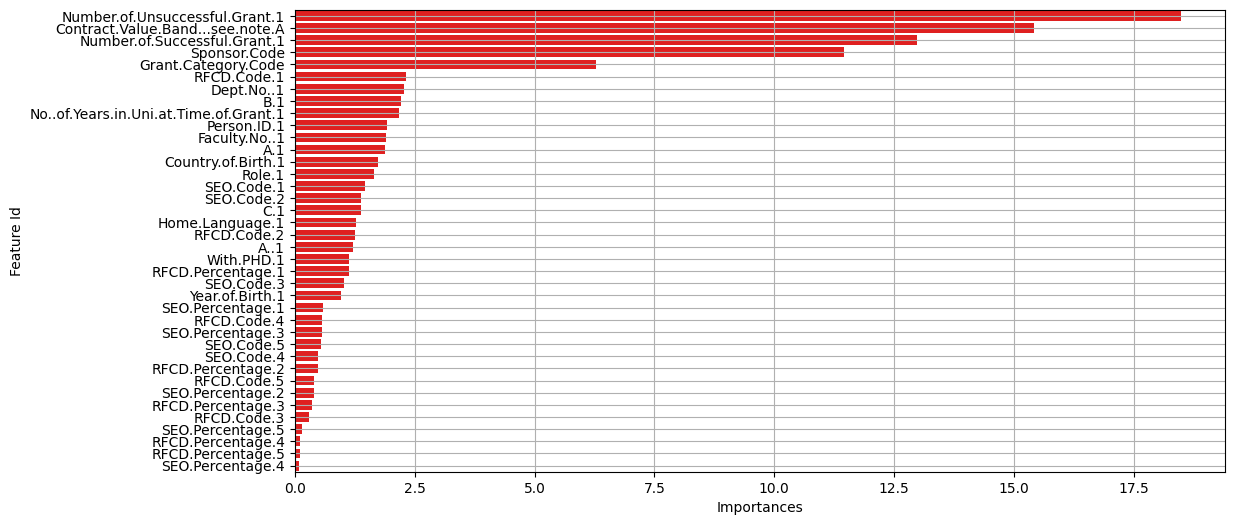

In [7]:
# Посмотрим на важность фич

plt.figure(figsize=(12, 6))
sns.barplot(data = cbc_1.get_feature_importance(prettified=True), x = 'Importances', y = 'Feature Id', color='red')
plt.grid()
plt.show()

In [8]:
# Посмотрим, что покажет кросс-валидация

params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 200,
    'random_seed': SEED,
    'cat_features': cat_features
}

all_train_data = Pool(data=features, label=target, cat_features=cat_features)

scores = catboost.cv(pool=all_train_data,
            params=params, 
            fold_count=4,
            seed=SEED, 
            shuffle=True,
            stratified=True,
            plot=True,
           )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]
0:	test: 0.8743765	best: 0.8743765 (0)	total: 38.3ms	remaining: 38.3s
200:	test: 0.9479072	best: 0.9481251 (199)	total: 3.72s	remaining: 14.8s
400:	test: 0.9500000	best: 0.9500000 (399)	total: 7.88s	remaining: 11.8s
600:	test: 0.9518348	best: 0.9518348 (600)	total: 11.8s	remaining: 7.81s
800:	test: 0.9527120	best: 0.9528611 (791)	total: 15.6s	remaining: 3.88s
999:	test: 0.9529585	best: 0.9533771 (897)	total: 19.1s	remaining: 0us

bestTest = 0.9533770999
bestIteration = 897

Training on fold [1/4]
0:	test: 0.8558110	best: 0.8558110 (0)	total: 19.8ms	remaining: 19.8s
200:	test: 0.9409581	best: 0.9411358 (195)	total: 3.48s	remaining: 13.8s
400:	test: 0.9424202	best: 0.9428100 (383)	total: 7.49s	remaining: 11.2s
600:	test: 0.9437618	best: 0.9439338 (519)	total: 11.7s	remaining: 7.75s
800:	test: 0.9444269	best: 0.9446391 (783)	total: 16.2s	remaining: 4.01s
999:	test: 0.9441460	best: 0.9446964 (854)	total: 20.4s	remaining: 0us

bestTest = 0.944696405
bestIteration = 85

In [9]:
scores[scores['test-AUC-mean'] == scores['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
518,518,0.94299,0.010545,0.237814,0.015491,0.154724,0.008774


ИТОГ:

1. Обучение происходит довольно быстро, дефолтная модель на моём ПК обучилась за 17с на датасете с ~ 4000 сэмплов; кросс-валидация на 4 фолдах заняла полторы минуты.
2. В данной версии предобработки данных нет (catboost сам обрабатывает пропущенные значения), что существенно экономит время;
3. Средний auc, показанный на кросс-валидации равен 0.943, что является лучшим результатом серди всех методов.